In [ ]:
#!pip3 install -q mediapipe
#!pip3 install -q imageio
#!pip3 install -q sklearn
#!pip3 install -q torch

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pickle
import json


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import random
import time
from sklearn.metrics import pairwise_distances


# modulos 
import sys
sys.path.append('../')
from shared_elements.lstm import SignLSTM
from shared_elements.shared_utils import detect_active_window
from shared_elements.shared_utils import fix_length
from shared_elements.shared_utils import get_holistic_model
from shared_elements.shared_utils import extract_keypoints_from_video
from shared_elements.shared_utils import compute_hand_fraction

# warning levels 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# "0" = all logs (default)
# "1" = filter out INFO
# "2" = filter out INFO + WARNING
# "3" = filter out INFO + WARNING + ERROR 

## Extract Keypoints

In [3]:
def process_videos_to_keypoints(data_folder, signs, output_base, holistic_params=None):
    """
    Recorre vídeos en data_folder/<sign>/, extrae keypoints y guarda .npy en output_base/<sign>/
    signs: lista de subcarpetas (etiquetas).
    holistic_params: dict con kwargs para get_holistic_model().
    """
    # inicializa modelo Holistic solo una vez
    model = get_holistic_model(**(holistic_params or {}))
    os.makedirs(output_base, exist_ok=True)

    for sign in signs:
        print(f"🫐 Procesando los videos del signo {sign}")
        in_dir  = os.path.join(data_folder, sign)
        out_dir = os.path.join(output_base, sign)
        os.makedirs(out_dir, exist_ok=True)

        video_files = [f for f in os.listdir(in_dir)
                       if f.lower().endswith(('.mp4','.avi','.mov','.webm'))]
        if not video_files:
            print(f"⚠️ No hay videos para el signo '{sign}' en {in_dir}")
            continue

        for vf in video_files:
            vp = os.path.join(in_dir, vf)
            keypts = extract_keypoints_from_video(vp, holistic_model=model)
            if keypts.size == 0:
                print(f"⚠️ No se extrajeron keypoints de {vf}")
                continue
            out_path = os.path.join(out_dir, os.path.splitext(vf)[0] + '.npy')
            np.save(out_path, keypts)
            # print(f"guardado: {out_path}")

    print("🎉 Extracción completada.")

In [4]:
data_source_folder = '../data/videos/'
data_output_folder = '../data/keypoints'
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

process_videos_to_keypoints(
    data_folder=data_source_folder,
    signs=signs,
    output_base=data_output_folder
)

I0000 00:00:1747594647.125616 1964309 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747594647.178125 1964487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747594647.186094 1964487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747594647.187157 1964492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747594647.187182 1964484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747594647.187233 1964485 inference_feedback_manager.cc:114] Feedback manager requires a

🫐 Procesando los videos del signo hello
🫐 Procesando los videos del signo bye
🫐 Procesando los videos del signo world
🫐 Procesando los videos del signo thank_you
🫐 Procesando los videos del signo yes
🫐 Procesando los videos del signo no
🫐 Procesando los videos del signo please
🫐 Procesando los videos del signo sorry
🫐 Procesando los videos del signo good
🫐 Procesando los videos del signo bad
🫐 Procesando los videos del signo me
🫐 Procesando los videos del signo you
🫐 Procesando los videos del signo love
🫐 Procesando los videos del signo help
🫐 Procesando los videos del signo stop
🎉 Extracción completada.


## Data augmentation

Antes de abordar el apartado de aumentación de datos, considero importante contextualizar la situación actual del conjunto de entrenamiento y los motivos por los que esta fase requiere especial atención.

En este momento, todos los datos con los que estoy entrenando el modelo han sido grabados por mí misma. Esto introduce una limitación significativa: la homogeneidad en las características de las secuencias.

Cuando una sola persona genera todos los gestos, inevitablemente se repiten ciertos patrones corporales —postura, proporciones, forma de extender los brazos o flexionar las manos— que, aunque sutiles, se reflejan en los keypoints. El modelo puede acabar asociando estos patrones personales con las etiquetas, más que aprender realmente el gesto en sí.

Además, suele haber una coherencia involuntaria en las secuencias. El ritmo, la orientación del cuerpo, e incluso la amplitud de los movimientos tienden a mantenerse relativamente constantes cuando provienen de una única fuente. Esto reduce considerablemente la variabilidad del conjunto de datos.

Otro punto clave es la distribución espacial repetitiva. Aunque MediaPipe abstrae del fondo y de las condiciones externas, la posición relativa de los keypoints en el espacio permanece estable entre grabaciones realizadas por la misma persona. Esto hace que el modelo pueda acostumbrarse demasiado a ese “marco espacial” concreto.

Por todos estos motivos, es fundamental introducir aumentación de datos. Sin embargo, esta es una tarea que hay que hacer con especial cuidado. En el caso de lengua de signos, Los gestos suelen diferenciarse entre sí por matices muy finos —una rotación específica, un cambio en la orientación de la mano— y cualquier alteración brusca puede hacer que el gesto deje de tener sentido. Por ejemplo, en signos como “bueno” y “malo”, lo que cambia es una pequeña inversión en el giro de la mano. Si al aplicar aumentación distorsionamos eso, estamos enseñando al modelo información errónea.

Por tanto, el reto aquí es lograr una aumentación que simule la variabilidad entre personas —como si los gestos vinieran de diferentes usuarios— pero sin destruir la esencia del movimiento. El objetivo es que el modelo aprenda a reconocer el gesto, no a la persona que lo ejecuta.



In [7]:

# Parámetros base
DEFAULT_PARAMS = dict(
    JITTER_STD_RANGE = (0.0001, 0.002),   # ruido gaussiano en X,Y,Z 
    SCALE_RANGE     = (0.99, 1.01),       # escala global 
    TRANSL_RANGE    = 0.005,              # traslación global 
    ROT_ANGLE_DEG   = 2,                  # rotación alrededor de Z
    DROPOUT_RATE    = 0.01,               # keypoints “caídos”
    WARP_PROB       = 0.01                # probabilidad de warp 
)

# Ajustes finos para clases problemáticas
CLASS_ADJUST = {
    'thank_you': dict(JITTER_STD_RANGE=(0.002, 0.008), WARP_PROB=0.05),
    'yes':       dict(JITTER_STD_RANGE=(0.001, 0.005), WARP_PROB=0.03),
    'no':        dict(JITTER_STD_RANGE=(0.001, 0.005), WARP_PROB=0.03),
}

def augment_sequence(
    seq, sign,
    enable_jitter=True,
    enable_scale=True,
    enable_translate=True,
    enable_rotate=True,
    enable_dropout=False,
    enable_temporal_warp=False
):
    """
    Toma una secuencia de forma (T, K, 3) y devuelve una versión aumentada.
    NO modifica la longitud de la secuencia.

    Transformaciones aplicadas:
      1. Jitter gaussiano en X,Y,Z
      2. Escalado global
      3. Traslación global
      4. Rotación en el plano XY
      5. Dropout de keypoints
      6. Warp temporal (duplicar o saltar frames)
    """
    
    # parámetros específicos por clase
    params = DEFAULT_PARAMS.copy()
    if sign in CLASS_ADJUST:
        params.update(CLASS_ADJUST[sign])

    JITTER_STD_RANGE  = params['JITTER_STD_RANGE']
    SCALE_RANGE   = params['SCALE_RANGE']
    TRANSL_RANGE  = params['TRANSL_RANGE']
    ROT_ANGLE_DEG = params['ROT_ANGLE_DEG']
    DROPOUT_RATE  = params['DROPOUT_RATE']
    WARP_PROB     = params['WARP_PROB']

    out = seq.copy()
    T, K, _ = out.shape

    # 1) Jitter gaussiano en X, Y, Z
    if enable_jitter and sign not in ['hello', 'yes', 'no']:
        sigma = np.random.uniform(*JITTER_STD_RANGE)
        noise = np.random.normal(0, sigma, size=(T, K, 3))
        out += noise

    # 2) Escalado global
    if enable_scale:
        factor = np.random.uniform(*SCALE_RANGE)
        out *= factor

    # 3) Traslación global en X, Y, Z
    if enable_translate:
        t = np.random.uniform(-TRANSL_RANGE, TRANSL_RANGE, size=(1, 1, 3))
        out += t

    # 4) Rotación alrededor de Z (plano XY)
    if enable_rotate:
        theta = np.deg2rad(np.random.uniform(-ROT_ANGLE_DEG, ROT_ANGLE_DEG))
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s, 0],
                      [s,  c, 0],
                      [0,  0, 1]])
        out = out.reshape(-1, 3) @ R.T
        out = out.reshape(T, K, 3)

    # 5) Dropout de keypoints aleatorio
    if enable_dropout:
        mask = np.random.rand(T, K) < DROPOUT_RATE
        out[mask] = 0.0

    # 6) Warp temporal (duplicar o saltar frames)
    if enable_temporal_warp and T > 5:
        new_seq = []
        for i in range(T):
            new_seq.append(out[i])
            if np.random.rand() < WARP_PROB:
                if np.random.rand() < 0.5:
                    new_seq.append(out[i])  # duplicar
                else:
                    continue  # saltar
        out = np.stack(new_seq, axis=0)

    return out


def generate_augmented_dataset(
    input_folder,
    output_folder,
    signs,
    augmentations_per_sample=5
):
    """
    Para cada .npy en input_folder/<sign>, genera `augmentations_per_sample`
    versiones aumentadas y las guarda en output_folder/<sign>.
    """
    os.makedirs(output_folder, exist_ok=True)

    for sign in signs:
        in_dir  = os.path.join(input_folder, sign)
        out_dir = os.path.join(output_folder, sign)
        os.makedirs(out_dir, exist_ok=True)

        for fname in os.listdir(in_dir):
            if not fname.endswith(".npy"):
                continue
            seq = np.load(os.path.join(in_dir, fname))  # forma (T, K, 3)
            base = fname.replace(".npy", "")

            # Guardar la secuencia original
            np.save(os.path.join(out_dir, f"{base}.npy"), seq)

            # Generar y guardar augmentaciones
            for i in range(augmentations_per_sample):
                aug = augment_sequence(seq, sign)
                np.save(os.path.join(out_dir, f"{base}_aug{i}.npy"), aug)

    print("✅ Dataset aumentado creado en", output_folder)


In [8]:
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

generate_augmented_dataset(
    input_folder="../data/keypoints",
    output_folder="../data/keypoints_augmented",
    signs=signs,
    augmentations_per_sample=5
)

✅ Dataset aumentado creado en ../data/keypoints_augmented


## Consideraciones sobre la duración de los gestos y normalización temporal

Uno de los requisitos habituales cuando se trabaja con redes neuronales es que las secuencias de entrada tengan siempre la misma longitud. Sin embargo, cuando se trata de vídeos de lenguaje de signos, esto plantea un problema importante: **los gestos no duran todos lo mismo**.

Hay signos que son breves y directos, y otros que requieren movimientos más amplios o complejos. A esto se suma una dificultad práctica en la forma en la que he grabado los vídeos: al igual que en la aplicación de grabación, el gesto comienza cuando pulso la barra espaciadora, lo que introduce algunos frames al principio y al final que **no forman parte real del gesto**, sino del movimiento de preparación o de cierre.

Esto significa que si tomamos todos los frames del vídeo sin procesarlos, estaremos alimentando al modelo con información que no es representativa, e incluso puede ser contradictoria.

Voy a definir una función llamada `detect_active_window(seq)` que nos ayudará a **detectar la “ventana activa” del gesto**, es decir, el rango de frames donde realmente está ocurriendo el movimiento significativo.

Entonces:

* Calculamos la velocidad frame-a-frame

  $$
    v_t = \sum_i \|\mathbf{k}_{t,i} - \mathbf{k}_{t-1,i}\|
  $$
* Encontramos

  $$
    t_{\min} = \min\{t : v_t > \tau\},\quad
    t_{\max} = \max\{t : v_t > \tau\}
  $$

  con un umbral $\tau$ en, digamos, el 10 % de la velocidad máxima de la secuencia.
* Devolvemos

  1. `seq_active = seq[t_min:t_max+1]`
  2. `duration = t_max - t_min + 1`


In [9]:
# recorremos el dataset de entrenamiento
DATA_FOLDER = '../data/keypoints'
signs = [d for d in os.listdir(DATA_FOLDER) if os.path.isdir(os.path.join(DATA_FOLDER, d))]

durations_by_sign = {}
all_durations = []

for sign in signs:
    folder = os.path.join(DATA_FOLDER, sign)
    durations = []
    for fname in os.listdir(folder):
        if not fname.endswith('.npy'):
            continue
        seq = np.load(os.path.join(folder, fname))
        _, _, dur = detect_active_window(seq)
        durations.append(dur)
        all_durations.append(dur)
    durations_by_sign[sign] = np.array(durations)

#  estadísticas por signo y global
print("Duraciones por signo:")
for sign, durs in durations_by_sign.items():
    mu = durs.mean()
    sigma = durs.std()
    print(f"  {sign:12s}  μ = {mu:.1f},  σ = {sigma:.1f}")

global_mu = np.mean(all_durations)
global_sigma = np.std(all_durations)
p90 = np.percentile(all_durations, 90)

print(f"\nGlobal:  μ = {global_mu:.1f},  σ = {global_sigma:.1f}")
print(f"Percentil 90% de duraciones activas: X = {p90:.0f} frames")


Duraciones por signo:
  please        μ = 29.9,  σ = 34.7
  thank_you     μ = 7.7,  σ = 10.9
  no            μ = 19.3,  σ = 20.3
  love          μ = 38.0,  σ = 11.3
  bad           μ = 53.7,  σ = 11.5
  world         μ = 66.6,  σ = 8.4
  stop          μ = 40.4,  σ = 9.2
  bye           μ = 20.1,  σ = 24.4
  good          μ = 57.9,  σ = 22.1
  me            μ = 39.5,  σ = 11.5
  hello         μ = 15.0,  σ = 15.4
  you           μ = 42.5,  σ = 6.9
  yes           μ = 25.2,  σ = 26.8
  sorry         μ = 77.0,  σ = 40.5
  help          μ = 30.9,  σ = 12.2

Global:  μ = 37.6,  σ = 27.8
Percentil 90% de duraciones activas: X = 73 frames


**RESULTADOS**: 


**Keypoints originales**
```markdown
Duraciones por signo:
  please        μ = 29.9,  σ = 34.6
  thank_you     μ = 7.7,  σ = 10.9
  no            μ = 19.3,  σ = 20.3
  love          μ = 38.0,  σ = 11.3
  bad           μ = 53.9,  σ = 11.7
  world         μ = 66.6,  σ = 8.4
  stop          μ = 40.7,  σ = 9.2
  bye           μ = 20.2,  σ = 24.7
  good          μ = 57.8,  σ = 22.1
  me            μ = 40.2,  σ = 10.5
  hello         μ = 15.0,  σ = 15.4
  you           μ = 42.6,  σ = 6.9
  yes           μ = 25.2,  σ = 26.8
  sorry         μ = 78.5,  σ = 39.3
  help          μ = 30.6,  σ = 12.5

Global:  μ = 37.7,  σ = 27.8
Percentil 90% de duraciones activas: X = 73 frames
````

**Datos aumentados**
```markdown
Duraciones por signo:
  please        μ = 64.2,  σ = 23.4
  thank_you     μ = 26.5,  σ = 11.3
  no            μ = 39.4,  σ = 15.1
  love          μ = 55.9,  σ = 11.1
  bad           μ = 67.0,  σ = 9.9
  world         μ = 75.9,  σ = 10.8
  stop          μ = 54.1,  σ = 9.0
  bye           μ = 49.5,  σ = 20.3
  good          μ = 81.7,  σ = 15.3
  me            μ = 44.0,  σ = 6.1
  hello         μ = 31.0,  σ = 11.8
  you           μ = 44.8,  σ = 5.6
  yes           μ = 47.5,  σ = 20.4
  sorry         μ = 100.8,  σ = 21.0
  help          μ = 53.3,  σ = 12.5

Global:  μ = 55.7,  σ = 23.9
Percentil 90% de duraciones activas: X = 88 frames
```

Considero que tiene más sentido fijarnos en la media y las distribuciones de los datos originales. Al aumentar los datos, el temporal‐warp que duplica o salta fames, ha elevando la media global y el percentil. Esto es normal pero no refleja la duración natural del gesto, sino el efecto artificial de la aumentación. Considero que lo más oportuno es fijar como número de Frames 73, ya que mantiene la duración realista del gesto para la red. 


Ahora vamos a ajustar todas las secuencias a una duración común. Esto es importante no solo porque las redes neuronales requieren entradas de longitud fija, sino también porque tener secuencias demasiado largas o demasiado cortas puede introducir ruido o hacer perder información útil.
Para ello 

1) Detectamos la ventana activa de cada secuencia (usando la función detect_active_window anterior).
2) Extraemos `seq_active = seq[t_start:t_end+1]`
    * Si duration ≥ 73, aplica un center crop de longitud 73.
    * Si duration < 73, genera padding equitativo antes y después para centrar la parte activa.
3) Guardamos la secuencia resultante en data/keypoints_fixed/<sign>/<archivo>.npy.
4) Guardamos un JSON con:
    * El nombre original de archivo.
    * t_start, t_end.
    * duration real.
    * target_length usado (73).



In [10]:

# Parámetros
TARGET_LENGTH = 73
DATA_FOLDER = '../data/keypoints_augmented'          # carpeta con secuencias originales .npy organizadas por signo
OUTPUT_SEQ_FOLDER = '../data/keypoints_fixed'    # donde guardar secuencias recortadas/pad
OUTPUT_META_FOLDER = '../data/keypoints_metadata' # donde guardar JSON de metadatos

# Crear carpetas de salida
os.makedirs(OUTPUT_SEQ_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_META_FOLDER, exist_ok=True)

# Recorrer dataset
for sign in os.listdir(DATA_FOLDER):
    in_dir = os.path.join(DATA_FOLDER, sign)
    if not os.path.isdir(in_dir):
        continue
    out_seq_dir = os.path.join(OUTPUT_SEQ_FOLDER, sign)
    out_meta_dir = os.path.join(OUTPUT_META_FOLDER, sign)
    os.makedirs(out_seq_dir, exist_ok=True)
    os.makedirs(out_meta_dir, exist_ok=True)

    for fname in os.listdir(in_dir):
        if not fname.endswith('.npy'):
            continue
        path_in = os.path.join(in_dir, fname)
        seq = np.load(path_in)  # (T, K, 3)

        # 1) Detectar ventana activa y duración
        t_start, t_end, duration = detect_active_window(seq)
        seq_active = seq[t_start:t_end+1]

        # 2) Center-crop o pad para TARGET_LENGTH
        seq_fixed = fix_length(seq_active, TARGET_LENGTH)
        
        # 3) Guardar secuencia fija
        out_seq_path = os.path.join(out_seq_dir, fname)
        np.save(out_seq_path, seq_fixed)

        # 4) Guardar metadatos
        meta = {
            'original_file': fname,
            't_start': int(t_start),
            't_end': int(t_end),
            'duration': int(duration),
            'target_length': TARGET_LENGTH
        }
        meta_path = os.path.join(out_meta_dir, fname.replace('.npy', '.json'))
        with open(meta_path, 'w') as f:
            json.dump(meta, f, indent=2)

print("✅ Secuencias fijas y metadatos guardados.")


✅ Secuencias fijas y metadatos guardados.


Para cuantificar de forma objetiva cuánto ruido hemos introducido y, al mismo tiempo, si los gestos siguen siendo distinguibles entre sí, utilizaremos:

1. Métricas de variación respecto a la secuencia original

2. Métricas de separabilidad de clases tras la augmentación

In [12]:
def mse_rmse(orig, aug):
    """
    Calcula MSE y RMSE entre dos secuencias de igual forma.
    orig, aug: np.ndarray shape (T, K, 3)
    """
    diff = orig - aug
    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    return mse, rmse


def snr_db(orig, aug):
    """
    Calcula el Signal-to-Noise Ratio en decibelios.
    """
    signal_power = np.sum(orig ** 2)
    noise_power = np.sum((orig - aug) ** 2)
    if noise_power == 0:
        return np.inf
    return 10 * np.log10(signal_power / noise_power)


def dtw_distance(s1, s2):
    """
    Distancia DTW entre dos secuencias (T1,K,3) y (T2,K,3).
    Se aplana cada frame a vector de características.
    """
    # Aplanar por frame
    f1 = s1.reshape(s1.shape[0], -1)
    f2 = s2.reshape(s2.shape[0], -1)
    n, m = f1.shape[0], f2.shape[0]
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(f1[i - 1] - f2[j - 1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    return dtw[n, m]


def load_dataset(folder, signs):
    """
    Carga todas las secuencias .npy de `folder/<sign>/` en un dict.
    Retorna dict: sign -> list of np.ndarray sequences.
    """
    data = {}
    for sign in signs:
        path = os.path.join(folder, sign)
        seqs = []
        for fname in os.listdir(path):
            if fname.endswith('.npy'):
                seq = np.load(os.path.join(path, fname))
                seqs.append(seq)
        data[sign] = seqs
    return data


def sample_intra_inter(data, metric_fn, n_intra_per_class=100, n_inter=5000, random_seed=42):
    """
    Muestra aleatoriamente pares intra- e inter-clase para calcular distancias promedio.
    - n_intra_per_class: número de pares a muestrear por clase.
    - n_inter: número total de pares inter-clase a muestrear.
    """
    random.seed(random_seed)
    # Intra-clase
    intra_vals = []
    for sign, seqs in data.items():
        n = len(seqs)
        all_indices = [(i, j) for i in range(n) for j in range(i+1, n)]
        sampled = random.sample(all_indices, min(n_intra_per_class, len(all_indices)))
        for i, j in sampled:
            d = metric_fn(seqs[i], seqs[j]) if metric_fn.__name__ == 'dtw_distance' else metric_fn(seqs[i], seqs[j])[0]
            intra_vals.append(d)
    # Inter-clase
    signs = list(data.keys())
    inter_vals = []
    for _ in range(n_inter):
        s1, s2 = random.sample(signs, 2)
        seq1 = random.choice(data[s1])
        seq2 = random.choice(data[s2])
        d = metric_fn(seq1, seq2) if metric_fn.__name__ == 'dtw_distance' else metric_fn(seq1, seq2)[0]
        inter_vals.append(d)
    return np.mean(intra_vals), np.mean(inter_vals)


def compute_cluster_metrics(data):
    """
    Calcula silhouette y Davies-Bouldin en dataset aplanado.
    """
    X = []
    y = []
    for sign, seqs in data.items():
        for seq in seqs:
            X.append(seq.reshape(-1))
            y.append(sign)
    X = np.stack(X)
    y = np.array(y)
    sil = silhouette_score(X, y)
    db = davies_bouldin_score(X, y)
    return sil, db

In [13]:
DATA_FOLDER = '../data/keypoints_fixed'  
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

# cargamos todo el dataset en un dict
data = load_dataset(DATA_FOLDER, signs)
# Comprueba cuántas secuencias por signo:
for s in signs:
    print(f"{s:12s}: {len(data[s])} secuencias")


hello       : 360 secuencias
bye         : 360 secuencias
world       : 360 secuencias
thank_you   : 360 secuencias
yes         : 360 secuencias
no          : 360 secuencias
please      : 360 secuencias
sorry       : 360 secuencias
good        : 360 secuencias
bad         : 360 secuencias
me          : 360 secuencias
you         : 360 secuencias
love        : 360 secuencias
help        : 360 secuencias
stop        : 360 secuencias


1. Error Cuadrático Medio (MSE) / Distancia Euclídea media
   Para cada par (original, aumentado) calculamos

   $$
     \mathrm{MSE} = \frac{1}{T\,K}\sum_{t=1}^T\sum_{i=1}^K
        \bigl\|\mathbf{x}_{t,i}^{\rm orig} - \mathbf{x}_{t,i}^{\rm aug}\bigr\|^2
   $$

   Indica en promedio cuánto se ha desviado cada keypoint. **Bajo** (< 0.02) = muy poco ruido; **alto** (> 0.10) = ruido agresivo.

2. Distancia Dinámica de Tiempo (DTW)
   Mide la “distancia mínima” alineando temporalmente dos secuencias de vectores. Es útil si el warp temporal variable cambia la velocidad del gesto:

   $$
     \mathrm{DTW}(\mathbf{X},\mathbf{Y}) = \min_{\pi}\sum_{(t,u)\in\pi}
        \bigl\|\mathbf{x}_t - \mathbf{y}_u\bigr\|
   $$

   donde $\pi$ es una ruta de alineación. **Bajo** (< 0.15)  el gesto, pese al ruido/warp, conserva muy bien la forma; **alto** (> 0.30) indica mucha distorsión.

3. Índice de Señal-Ruido (SNR)
   Calcula “potencia” del gesto frente a la “potencia” del ruido que se añade:

   $$
     \mathrm{SNR} = 10\,\log_{10}\frac{\sum_{t,i}\|\mathbf{x}_{t,i}^{\rm orig}\|^2}
                                 {\sum_{t,i}\|\mathbf{x}_{t,i}^{\rm aug}-\mathbf{x}_{t,i}^{\rm orig}\|^2}
   $$

   Sirve para calibrar el nivel de jitter/warp.
      • **> 20 dB** → ruido casi inapreciable
      • **0 … +20 dB** → ruido moderado
      • **< 0 dB** → el ruido supera a la señal → **demasiado fuerte**

In [14]:
# 4) Métricas entre original vs primera augmentación de cada signo
print("=== Original vs Augmentación ===")
for sign in signs:
    path = os.path.join(DATA_FOLDER, sign)
    files = sorted([f for f in os.listdir(path) if f.endswith('.npy')])
    orig_files = [f for f in files if '_aug' not in f]
    aug_files  = [f for f in files if '_aug' in f]
    if not orig_files or not aug_files:
        continue
    orig = np.load(os.path.join(path, orig_files[0]))
    aug  = np.load(os.path.join(path, aug_files[0]))
    mse, rmse = mse_rmse(orig, aug)
    snr       = snr_db(orig, aug)
    dtw       = dtw_distance(orig, aug)
    print(f"{sign:12s} MSE={mse:.6f}, RMSE={rmse:.6f}, SNR={snr:.2f} dB, DTW={dtw:.4f}")


=== Original vs Augmentación ===
hello        MSE=0.051531, RMSE=0.227003, SNR=-13.90 dB, DTW=127.0610
bye          MSE=0.000001, RMSE=0.000770, SNR=40.10 dB, DTW=0.1808
world        MSE=0.061814, RMSE=0.248624, SNR=4.23 dB, DTW=123.3330
thank_you    MSE=0.000004, RMSE=0.002039, SNR=33.81 dB, DTW=0.3883
yes          MSE=0.055782, RMSE=0.236182, SNR=-5.20 dB, DTW=66.9847
no           MSE=0.016363, RMSE=0.127917, SNR=0.56 dB, DTW=7.3720
please       MSE=0.000033, RMSE=0.005723, SNR=19.70 dB, DTW=0.5848
sorry        MSE=0.303943, RMSE=0.551311, SNR=-16.39 dB, DTW=449.0339
good         MSE=0.063789, RMSE=0.252566, SNR=5.53 dB, DTW=144.2238
bad          MSE=0.123700, RMSE=0.351710, SNR=3.53 dB, DTW=100.8143
me           MSE=0.087076, RMSE=0.295087, SNR=4.52 dB, DTW=22.6294
you          MSE=0.041587, RMSE=0.203929, SNR=6.18 dB, DTW=19.8195
love         MSE=0.042541, RMSE=0.206255, SNR=4.56 dB, DTW=26.4821
help         MSE=0.046677, RMSE=0.216048, SNR=4.61 dB, DTW=77.5262
stop         MSE=0.0

**Matriz de distancias intra / inter-clase**

   * Intra-clase: media de distancias (MSE, DTW…) entre todas las parejas dentro de un mismo signo (incluyendo originales y sus augmentaciones).
   * Inter-clase: media de distancias entre parejas de signos distintos.

   Se debe buscar que

   $$
     \text{dist}_{\rm intra} \ll \text{dist}_{\rm inter}.
   $$

   Si la augmentación hace crecer mucho $\text{dist}_{\rm intra}$, el modelo tendrá más dificultad para agrupar esas muestras.
   $\text{intra} \ll \text{inter}$.
   Si se aproximan, las clases se solapan.

In [15]:
# Medir tiempo con MSE
print("=== Intra vs Inter ===")
mse_intra_samp, mse_inter_samp = sample_intra_inter(data, mse_rmse, n_intra_per_class=200, n_inter=2000)
print(f"Sampled MSE Intra={mse_intra_samp:.6f}, Inter={mse_inter_samp:.6f}")

# Medir tiempo con DTW
dtw_intra_samp, dtw_inter_samp = sample_intra_inter(data, dtw_distance, n_intra_per_class=100, n_inter=1000)
print(f"Sampled DTW Intra={dtw_intra_samp:.6f}, Inter={dtw_inter_samp:.6f}")


=== Intra vs Inter ===
Sampled MSE Intra=0.060310, Inter=0.119502
Sampled DTW Intra=82.279126, Inter=171.602348


**Silhouette Score**

   Calcula para cada muestra $i$

   $$
     s(i) = \frac{b(i) - a(i)}{\max\{a(i),\,b(i)\}},
   $$

   donde

   * $a(i)$ = promedio de distancia de la muestra $i$ a las demás de su misma clase.
   * $b(i)$ = mínima promedio de distancia al resto de clases.

   El silhouette medio entre $-1$ y $+1$ indica cuán bien de separadas están las clases tras introducir ruido.
      • **> 0.3** → clusters densos, bien separados
      • **0 … 0.3** → separación débil, algo de solapamiento
      • **< 0** → clusters mal formados, mezcla fuerte


**Índice de Davies–Bouldin**


   Mide la ratio de “dispersion intra-clase” a “separación inter-clase” de todos los pares de clusters. Valores menores indican mejor agrupamiento:

   $$
     \mathrm{DB} = \frac{1}{C}\sum_{i=1}^C \max_{j\neq i}\frac{\sigma_i + \sigma_j}{d(\mu_i,\mu_j)}
   $$

   donde $\sigma_i$ es la dispersión del cluster $i$ y $d(\mu_i,\mu_j)$ la distancia entre centroides.
      • **< 1.5** → buena separación inter-clase
      • **1.5 … 2.5** → moderada
      • **> 2.5** → clusters muy solapados

In [16]:
# 6) Métricas de clustering: Silhouette y Davies–Bouldin
sil, db = compute_cluster_metrics(data)
print("=== Separabilidad de clases ===")
print(f"Silhouette Score:     {sil:.3f}")
print(f"Davies-Bouldin Index: {db:.3f}")

=== Separabilidad de clases ===
Silhouette Score:     -0.071
Davies-Bouldin Index: 6.461


## Generate train test data

In [17]:
class SignDataset(Dataset):
    def __init__(self,
                 base_folder,       # carpeta con datos
                 signs,             # lista de signos
                 split='train',     # 'train' o 'val'
                 metadata_folder=None,  # 'carpeta con metadatos
                 val_list_file=None,    # ruta a val_list.txt o None
                 val_ratio=0.2,         # % para split si val_list_file es None
                 random_seed=42,
                 transform=None):
        """
        Si val_list_file es dado, los paths que aparezcan allí van a validation,
        y el resto a train. Si val_list_file es None, se hace un train_test_split
        estratificado con val_ratio.
        """
        self.transform = transform
        sign2idx = {s:i for i,s in enumerate(signs)}
        items = []

        # 1) Recolectar todos los ítems posibles
        for sign in signs:
            folder = os.path.join(base_folder, sign)
            for fn in os.listdir(folder):
                if not fn.endswith('.npy'): 
                    continue
                seq_path = os.path.join(folder, fn)
                # leemos duración desde JSON
                md_path = os.path.join(metadata_folder, sign, fn.replace('.npy','.json'))
                with open(md_path) as f:
                    duration = json.load(f)['duration']
                items.append((f"{sign}/{fn}", seq_path, duration, sign2idx[sign]))

        # 2a) si hay fichero de validación, lo cargamos
        if val_list_file:
            with open(val_list_file) as f:
                val_set = {line.strip() for line in f}
            # elegimos según val_list_file
            if split=='train':
                chosen = [it for it in items if it[0] not in val_set]
            else:
                chosen = [it for it in items if it[0]     in val_set]

        # 2b) si no, hacemos split aleatorio estratificado
        else:
            # extraemos etiquetas
            rel_paths, seq_paths, durations, labels = zip(*items)
            train_idx, val_idx = train_test_split(
                list(range(len(items))),
                test_size=val_ratio,
                random_state=random_seed,
                stratify=labels
            )
            idxs = train_idx if split=='train' else val_idx
            chosen = [items[i] for i in idxs]

        # 3) Guardamos solo lo elegido
        # de cada tupla tomamos (seq_path, duration, label_idx)
        self.items = [(seq_path, dur, lbl) for (_, seq_path, dur, lbl) in chosen]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        seq_path, duration, label = self.items[idx]
        # cargamos secuencia original (T,42,3)
        seq_kp = np.load(seq_path)
        # aplanamos a (T,126) y normalizamos
        seq_flat = seq_kp.reshape(73, -1).astype(np.float32)
        if self.transform:
            seq_flat = self.transform(seq_flat)
        # calculamos duration y hand fraction
        length    = np.array([duration / 73.0], dtype=np.float32)
        hand_frac = compute_hand_fraction(seq_kp)  # shape (1,)
        # devolvemos tensor de secuencia, length, hand_frac y label
        return (
            torch.from_numpy(seq_flat), 
            torch.from_numpy(length), 
            torch.from_numpy(hand_frac),
            label
        )


In [18]:

DATA_FOLDER     = '../data/keypoints_fixed'
META_FOLDER     = '../data/keypoints_metadata'
VAL_LIST_FILE   = '../data/val_list.txt'  # o None 
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

train_ds = SignDataset(
    base_folder      = DATA_FOLDER,
    signs            = signs,
    split            = 'train',
    metadata_folder  = META_FOLDER,
    val_list_file    = None, # VAL_LIST_FILE
    val_ratio        = 0.2,  # no poner si hay val list
    random_seed      = 42    # no poner si hay val list
)
val_ds= SignDataset(
    base_folder      = DATA_FOLDER,
    signs            = signs,
    split            = 'val',
    metadata_folder  = META_FOLDER,
    val_list_file    = None,
    val_ratio        = 0.2,
    random_seed      = 42
)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,    batch_size=batch_size, shuffle=False)

# Prueba un batch
for seqs, lengths, hands, labels in train_loader:
    print(seqs.shape, lengths.shape, labels.shape)
    break


torch.Size([32, 73, 126]) torch.Size([32, 1]) torch.Size([32])


In [19]:
# Recolectar todas las secuencias y etiquetas
all_seqs = []
all_labels = []
for seqs, lengths, hands, labels in train_loader:
    # seqs: (B, 73, 126), hands: (B, 1), labels: (B,)
    all_seqs.append(seqs.numpy())     # conviértelo a NumPy
    all_labels.append(labels.numpy())
all_seqs  = np.concatenate(all_seqs, axis=0)  # (N, 73, 126)
all_labels = np.concatenate(all_labels, axis=0)  # (N,)

# Aplanar etiquetas y ajustar LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(all_labels)

# Guarda el encoder
with open('../shared_elements/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# 3) Calcular media y desviación estándar de las características
#    media y std sobre ejes [muestra, frame], dejando vector de tamaño 126
X_mean = all_seqs.mean(axis=(0, 1))     # shape (126,)
X_std  = all_seqs.std(axis=(0, 1)) + 1e-6

# Guarda mean y std
np.save('../shared_elements/X_mean.npy', X_mean)
np.save('../shared_elements/X_std.npy',  X_std)

print("✅ Artefactos guardados:")
print("   - label_encoder.pkl")
print("   - X_mean.npy (shape {})".format(X_mean.shape))
print("   - X_std.npy  (shape {})".format(X_std.shape))


✅ Artefactos guardados:
   - label_encoder.pkl
   - X_mean.npy (shape (126,))
   - X_std.npy  (shape (126,))


In [20]:
# — RUTAS Y PARÁMETROS —
DATA_FOLDER     = '../data/keypoints_fixed'
META_FOLDER     = '../data/keypoints_metadata'
SHARED_FOLDER   = '../shared_elements'
SIGNS = [
    'hello','bye','world','thank_you','yes','no','please',
    'sorry','good','bad','me','you','love','help','stop'
]

lr         = 1e-3
epochs     = 50
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# — Carga de media y std para normalizar —
mean = np.load(os.path.join(SHARED_FOLDER, 'X_mean.npy'))  # shape (126,)
std  = np.load(os.path.join(SHARED_FOLDER, 'X_std.npy'))   # shape (126,)

def normalize(seq: np.ndarray) -> np.ndarray:
    # seq: (73,126)
    return (seq - mean) / std


# — Modelo, pérdida y optimizador —
model = SignLSTM(input_dim=126, hidden_dim=128, num_layers=1, num_classes=len(SIGNS))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# — Bucle de entrenamiento / validación —
best_val_acc = 0.0
for epoch in range(1, epochs+1):
    # entrenamiento
    model.train()
    train_correct = train_total = 0
    train_loss = 0.0
    for seqs, lengths, hands, labels in train_loader:
        seqs   = seqs.to(device)         # (B,73,126)
        lengths= lengths.to(device)      # (B,1)
        hands = hands.to(device)
        labels = labels.to(device)       # (B,)
        optimizer.zero_grad()
        logits = model(seqs, lengths, hands)    # (B,15)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss   += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_correct+= (preds==labels).sum().item()
        train_total  += labels.size(0)

    train_acc = train_correct / train_total
    train_loss/= train_total

    # validación
    model.eval()
    val_correct = val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for seqs, lengths, hands, labels in val_loader:
            seqs    = seqs.to(device)
            lengths = lengths.to(device)
            hands = hands.to(device)
            labels  = labels.to(device)
            logits  = model(seqs, lengths, hands)
            loss    = criterion(logits, labels)

            val_loss   += loss.item() * labels.size(0)
            preds      = logits.argmax(dim=1)
            val_correct+= (preds==labels).sum().item()
            val_total  += labels.size(0)

    val_acc = val_correct / val_total
    val_loss/= val_total

    print(f"Epoch {epoch:2d} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.3f}")

    # guardar mejor modelo en shared_elements/
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(),
                   os.path.join(SHARED_FOLDER, 'best_model.pt'))
        print(" ➤ Nuevo mejor modelo guardado")


Epoch  1 | Train loss 2.1397 acc 0.248 | Val loss 1.7198 acc 0.328
 ➤ Nuevo mejor modelo guardado
Epoch  2 | Train loss 1.5831 acc 0.365 | Val loss 1.4818 acc 0.415
 ➤ Nuevo mejor modelo guardado
Epoch  3 | Train loss 1.4355 acc 0.402 | Val loss 1.4187 acc 0.399
Epoch  4 | Train loss 1.3029 acc 0.460 | Val loss 1.3285 acc 0.439
 ➤ Nuevo mejor modelo guardado
Epoch  5 | Train loss 1.2114 acc 0.510 | Val loss 1.2564 acc 0.471
 ➤ Nuevo mejor modelo guardado
Epoch  6 | Train loss 1.1847 acc 0.532 | Val loss 1.1425 acc 0.551
 ➤ Nuevo mejor modelo guardado
Epoch  7 | Train loss 1.0589 acc 0.583 | Val loss 1.0844 acc 0.580
 ➤ Nuevo mejor modelo guardado
Epoch  8 | Train loss 0.9770 acc 0.621 | Val loss 0.9793 acc 0.593
 ➤ Nuevo mejor modelo guardado
Epoch  9 | Train loss 0.9214 acc 0.642 | Val loss 0.9689 acc 0.595
 ➤ Nuevo mejor modelo guardado
Epoch 10 | Train loss 0.8564 acc 0.665 | Val loss 1.0272 acc 0.587
Epoch 11 | Train loss 0.8477 acc 0.663 | Val loss 0.8757 acc 0.660
 ➤ Nuevo mejor 


Classification Report:
              precision    recall  f1-score   support

       hello       0.89      0.71      0.79        72
         bye       0.88      0.74      0.80        72
       world       1.00      1.00      1.00        72
   thank_you       0.90      0.39      0.54        72
         yes       0.70      0.78      0.74        72
          no       0.72      0.82      0.77        72
      please       0.55      0.93      0.69        72
       sorry       0.94      1.00      0.97        72
        good       0.96      0.97      0.97        72
         bad       1.00      0.99      0.99        72
          me       1.00      0.99      0.99        72
         you       0.99      0.96      0.97        72
        love       0.97      1.00      0.99        72
        help       1.00      0.97      0.99        72
        stop       1.00      0.97      0.99        72

    accuracy                           0.88      1080
   macro avg       0.90      0.88      0.88      1080
we

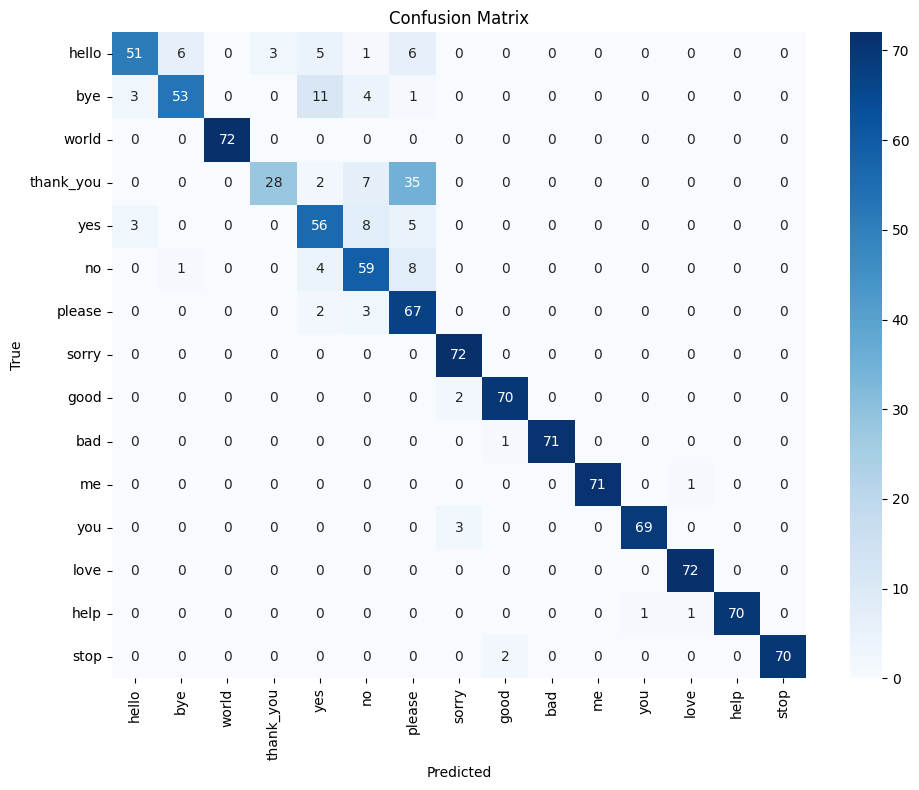

In [21]:
def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for seqs, lengths, hands, labels in data_loader:
            seqs    = seqs.to(device)
            lengths = lengths.to(device)
            hands = hands.to(device)
            labels  = labels.to(device)

            outputs = model(seqs, lengths, hands)
            preds   = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ahora pasamos class_names (una lista de strings)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Accuracy: {acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


evaluate_model(model, val_loader, device, signs)
